# $\textit{Detección de ondas gravitatorias}$
$\textit{Estimación Espectral No Paramétrica}$

In [ ]:
%matplotlib widget
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd

In [ ]:
# Creditos: https://stackoverflow.com/questions/31410043/hiding-lines-after-showing-a-pyplot-figure, by Basj

class InteractiveLegend(object):
    def __init__(self, legend=None):
        if legend == None:
            legend = plt.gca().get_legend()
        self.legend = legend
        self.fig = legend.axes.figure
        self.lookup_artist, self.lookup_handle = self._build_lookups(legend)
        self._setup_connections()
        self.update()
    def _setup_connections(self):
        for artist in self.legend.texts + self.legend.legendHandles:
            artist.set_picker(10) # 10 points tolerance
        self.fig.canvas.mpl_connect('pick_event', self.on_pick)
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)
    def _build_lookups(self, legend):
        labels = [t.get_text() for t in legend.texts]
        handles = legend.legendHandles
        label2handle = dict(zip(labels, handles))
        handle2text = dict(zip(handles, legend.texts))
        lookup_artist = {}
        lookup_handle = {}
        for artist in legend.axes.get_children():
            if artist.get_label() in labels:
                handle = label2handle[artist.get_label()]
                lookup_handle[artist] = handle
                lookup_artist[handle] = artist
                lookup_artist[handle2text[handle]] = artist
        lookup_handle.update(zip(handles, handles))
        lookup_handle.update(zip(legend.texts, handles))
        return lookup_artist, lookup_handle
    def on_pick(self, event):
        handle = event.artist
        if handle in self.lookup_artist:
            artist = self.lookup_artist[handle]
            artist.set_visible(not artist.get_visible())
            self.update()
    def on_click(self, event):
        if event.button == 3:
            visible = False
        elif event.button == 2:
            visible = True
        else:
            return
        for artist in self.lookup_artist.values():
            artist.set_visible(visible)
        self.update()
    def update(self):
        for artist in self.lookup_artist.values():
            handle = self.lookup_handle[artist]
            if artist.get_visible():
                handle.set_visible(True)
            else:
                handle.set_visible(False)
        self.fig.canvas.draw()

In [ ]:
sns.set_theme()

En un principio utilizamos el dataset de 4096s para asegurar buenos resultado y descartar que los errores que fueramos cometiendo sean causados por la baja cantidad de datos. Luego, probamos con el de 32s y genera resultados muy similares, por lo que decidimos quedarnos con el de 32s.

In [ ]:
# these 4096 second files are useful for computing more accurate psds
#largeFilenamePart = {'GW150914': 'GWOSC_4KHZ_R1-1126257415-4096.hdf5'}
largeFilenamePart = {'GW150914': 'GWOSC_4KHZ_R1-1126259447-32.hdf5'}
fn_H1 = './Data/H-H1_' + largeFilenamePart['GW150914']
fn_L1 = './Data/L-L1_' + largeFilenamePart['GW150914']

# this is the approximate event time which is used in the papers
time_center = 1126259462

# get sample rate from the H1 data file
with h5py.File(fn_H1, 'r') as hdf_file:
    dt = hdf_file['strain/Strain'].attrs['Xspacing']
fs = int(1.0/dt)
print("Using sample rate of {0} Hz found in file: {1}".format(fs, fn_H1))

In [ ]:
import readligo as rl
strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')

In [ ]:
len(strain_H1)

In [ ]:
indxt_around_H1 = np.where((time_H1 >= time_center - 2) & (time_H1 < time_center + 2))
indxt_around_L1 = np.where((time_L1 >= time_center - 2) & (time_L1 < time_center + 2))

# $\textit{Agarramos los datos sin el evento en ventanas}$

In [ ]:

#Getting a neighbourhood of the event
strain_H1_after_noise = strain_H1[indxt_around_H1[0][-1]+1:]
strain_L1_after_noise = strain_L1[indxt_around_L1[0][-1]+1:]
strain_H1_before_noise = strain_H1[:indxt_around_H1[0][0]]
strain_L1_before_noise = strain_L1[:indxt_around_L1[0][0]]

getChuncks = lambda lst, K: [lst[i:i + K] for i in range(0, len(lst), K)][:-1]


In [ ]:
len(getChuncks(strain_H1_after_noise, 100))

# $\textit{Estacionaridad}$

fuentes: https://arch.readthedocs.io/en/latest/unitroot/unitroot_examples.html

In [ ]:
len(strain_L1_before_noise)

In [ ]:
from arch.unitroot import ADF

''' 
Para el test, se tiene en cuenta que las hipotesis son:

H0: La serie contiene raiz unitaria.
H1: La serie es estacionaria.

Si el p-valor esta por encima del critico, la hipotesis nula no puede ser rechazada, indicando que 
la serie no es estacionaria.
'''

norm1 = strain_L1_before_noise * 1e18
norm2 = strain_H1_before_noise * 1e18
max_lags_test=len(strain_L1_before_noise)//50

adf = ADF(norm1, max_lags=max_lags_test)
print(adf.summary().as_text())
print("Dado que P-value = 0, podemos concluir que la señal L1 es estacionaria.")
print('\n//////////////////////////////////////\n')

adf = ADF(norm2, max_lags=max_lags_test)
print(adf.summary().as_text())
print("Dado que P-value = 0, podemos concluir que la señal H1 es estacionaria.")

In [ ]:
from arch.unitroot import PhillipsPerron

pp = PhillipsPerron(norm1)
print(pp.summary().as_text())
print("Dado que P-value = 0, podemos concluir que la señal L1 es estacionaria.")
print('\n//////////////////////////////////////\n')

pp = PhillipsPerron(norm2)
print(pp.summary().as_text())
print("Dado que P-value = 0, podemos concluir que la señal H1 es estacionaria.")

A traves de estos test, se concluyo la estacionaridad de los datos.

# $\textit{EDA}$

In [ ]:
plt.figure()
plt.plot(time_H1, strain_H1, linewidth=1, label='H1')
plt.plot(time_L1, strain_L1, linewidth=1, label='L1')
plt.legend()

In [ ]:
np.mean(strain_L1)

El dataset L1 se ve que tiene una media distinta de 0 con un valor considerablemente alto. Dado que el proceso se comprobo estacionario, es posible restarle esa media.

In [ ]:
strain_L1 = strain_L1-np.mean(strain_L1)

In [ ]:
indxt_around_L1

In [ ]:
plt.figure()
plt.plot(time_H1[indxt_around_H1], strain_H1[indxt_around_H1], linewidth=1)
plt.plot(time_L1[indxt_around_L1], strain_L1[indxt_around_L1], linewidth=1)

# $\textit{Prueba de ventanas}$

In [ ]:
from numpy.fft import fft, rfft
from numpy.fft import fftshift, fftfreq, rfftfreq
from scipy import signal as sg
from scipy.interpolate import interp1d

In [ ]:
N = 8192
n = np.linspace(0,N-1,N)

SquareW = sg.windows.boxcar(N) #Square window
TriangW = sg.windows.triang(N) #Triangular window
BlkHarrW = sg.windows.blackmanharris(N)
BlkW = sg.windows.blackman(N)

ParzenW = sg.windows.parzen(N)
kaiserW = sg.windows.kaiser(N, 10)
tukeyW = sg.windows.tukey(N, 0.9)   # 

currWindow = BlkW #Choose window

In [ ]:
fig, axs = plt.subplots(1, 2)
fig.tight_layout(pad=2)
fig.set_figwidth(8)


A = rfft(currWindow, N*10) 
box = rfft(SquareW, N*10)
freq = rfftfreq(N*10, 1/fs)
response = 10*np.log10((np.abs(A)+1e-1) / abs(A).max())
responsebox = 10*np.log10((np.abs(box)+1e-18) / abs(box).max())


axs[0].set_title("Window")
axs[0].plot(currWindow)

axs[1].set_title("Frec. response")
axs[1].plot(freq, responsebox, label='Box')
axs[1].plot(freq, response, label='blackman')
axs[1].set_xlabel("frecuency")
axs[1].set_ylabel("dB")
axs[1].set_xscale('log')
axs[1].set_ylim(-80, 1)
plt.legend()

# $\textit{Calculamos la PSD}$

In [ ]:
def PSD(seq, padding_mul):
    rv = sg.correlate(seq, seq)/len(seq)
    rx = rfft(rv, int(len(rv)*padding_mul))
    Rx = np.abs(rx)
    freq = rfftfreq(int(len(rv)*padding_mul), 1/fs)
    return freq, Rx

In [ ]:
def PSD(seq, padding_mult):
    SeqF = rfft(seq, int(len(seq)*padding_mult))
    psd = np.abs(SeqF)**2 / (len(seq))
    freq = rfftfreq(int(len(seq)*padding_mult), 1/fs)
    return freq, psd

In [ ]:
plt.figure()
rv = sg.correlate(strain_H1_after_noise, strain_H1_after_noise)/len(strain_H1_after_noise)
lags = sg.correlation_lags(len(strain_H1_after_noise), len(strain_H1_after_noise), mode ="full")
plt.plot(lags, rv)


Esta autocorrelacion se realiza a traves del camino de la fft utilizando todas las muestras presentes luego del evento del dataset de 4096 segundos. Se puede ver que la correlacion es mas alta dentro de un intervalo de aproximadamente 30 seg y luego se achica y parece permanecer con una amplitud mas pequeña en comparacion con el centro. Esto no necesariamente indica que las muestras sean poco correlacionadas en ventanas de 30 seg ya que no se puede asegurar la estacionaridad de la señal en el intervalo de tiempo utilizado. En caso de que fuera estacionario, este resultado es evidencia de que para intervalos de mas de 30 seg la correlacion es bastante menor.

A) Segun el grafico anterior, se presume que el ruido tiene correlacion en un intervalo de alrededor de 30 seg, por lo que a priori nos indica que deberiamos utilizar una ventana de datos mayor a 30 para evitar la perdida de informacion. Creemos que deberiamos usar un ventana de al menos 4 veces 30, es decir 120 segundos. Esto ultimo se vuelve impracticable debido a los recursos de computo necesarios. Por esto, se utilizo una ventana de 32 segundos.

In [ ]:
psd_freqH1, psdH1 = PSD(strain_H1_after_noise[:10*fs], 1)
psd_freqL1, psdL1 = PSD(strain_L1_after_noise[:10*fs], 1)

plt.figure()

plt.title("PSD")
plt.plot(psd_freqH1, psdH1, label='PSD H1')
plt.plot(psd_freqL1, psdL1, label='PSD L1')

plt.yscale('log')
plt.xlabel('Freq [Hz]')
plt.xlabel('PSD')
plt.legend(loc='upper right')
leg1 = InteractiveLegend()


# $\textit{Periodogram Averaging}$

C) Segun la teoria vista en clase, utilizamos N como la maxima cantidad de datos disponibles (quitando una seccion de 4 segundos donde se encuentra el evento). Este seccionado de los datos genera dos arreglos cuyos periodogramas se calculan por separado para luego ser promediados. Esto se basa en al suposicion de estacionaridad del proceso.

In [ ]:
def periodogram_averaging(data, L, padding_multiplier, window):
    wind = window(L)
    corrFact = np.sqrt(L/np.square(wind).sum()) #Normalizamos la ventana para que sea asintoticamente libre de bias
    wind =  wind*corrFact
    dataChunks = getChuncks(data, L)*wind
    fftwindowSize = L*padding_multiplier
    freqs = rfftfreq(fftwindowSize, 1/fs)
    periodogram = np.zeros(len(freqs))
    for i in range(len(dataChunks)):
        # Se van agregando al promediado los periodogramas de cada bloque calculado a partir de la FFT del señal en el tiempo
        periodogram = periodogram + np.abs(rfft(dataChunks[i], fftwindowSize))**2/(L*len(dataChunks))   

    return freqs, periodogram, len(dataChunks)


windows = ['boxcar', 'triang', 'parzen', 'bohman', 'blackman', 'nuttall',
           'blackmanharris', 'flattop', 'bartlett', 'barthann',
           'hamming', ('kaiser', 10), ('tukey', 0.25)]

## H1

Con este testeo de ventanas y cantidades de datos, se determino empiricamente que un buen valor para L es 4092 en gran parte de los casos. Este valor de K permite utilizar 26 periodogramas en el promedio, permitiendo reducir la varianza y dando valores similares al resultado de L=8096 pero con un ruido notablemente menor. Las ventanas cuadrada y de Hamming resultaron con un rendimiento pobre no pudiendo generar un periodograma aceptable, lo que probablemente se deba a su alto leakege espectral. En particular las ventanas de Parzen, blackmann y barthan arrojaron los resultados que creemos mejores para este caso. En aprticular se utilizo la ventana de blackmann, que se noto con una mejor definicion de los picos espectrales.

In [ ]:

plt.figure(figsize=(15, 50))
legsH1 = [0]*len(windows)

for i, win in enumerate(windows):
    plt.subplot(len(windows) // 2 + len(windows) % 2, 2, i+1)
    plt.plot(psd_freqH1, psdH1, label="No window")
    plt.title(f'Ventana: {win}')
    for size in [512, 2048, 4096, 8192, 16384]:
        window = lambda x: sg.windows.get_window(win, x)
        freqs, after_preiodogram, Kaf = periodogram_averaging(strain_H1_after_noise, size, 4, window)
        freqs, bf_preiodogram, Kbf = periodogram_averaging(strain_H1_before_noise, size, 4, window)
        mean_periodogram = (after_preiodogram + bf_preiodogram)/2
        plt.plot(freqs, mean_periodogram, label=f"L = {size}, K = {Kaf + Kbf}")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Freq [Hz]')
    plt.ylabel('PSD')
    plt.xlim(10, fs/2)
    plt.legend(loc='upper right')
    legsH1[i] = InteractiveLegend()



In [ ]:
size =4092
window = lambda x: sg.windows.get_window('blackman', x)
freqs, after_preiodogram, Kaf = periodogram_averaging(strain_H1_after_noise, size, 4, window)
paH1freqs, bf_preiodogram, Kbf = periodogram_averaging(strain_H1_before_noise, size, 4, window)
Rxpa_estH1 = (after_preiodogram + bf_preiodogram)/2

## L1

De forma similar al caso anterior se concluyo que los mismos parametros funcionan bastante bien. L=4092, ventana de Blackman, y la utilizacion de todos los datos disponibles, salvo la seccion donde se encuentra la señal.

In [ ]:
plt.figure(figsize=(15, 50))
legsL1 = [0]*len(windows)

for i, win in enumerate(windows):
    plt.subplot(len(windows) // 2 + len(windows) % 2, 2, i+1)
    plt.plot(psd_freqL1, psdL1, label="No window")
    plt.title(f'Ventana: {win}')
    for size in [512, 2048, 4096, 8192, 16384]:
        window = lambda x: sg.windows.get_window(win, x)
        freqs, after_preiodogram, Kaf = periodogram_averaging(strain_L1_after_noise, size, 4, window)
        freqs, bf_preiodogram, Kbf = periodogram_averaging(strain_L1_before_noise, size, 4, window)
        mean_periodogram = (after_preiodogram + bf_preiodogram)/2
        plt.plot(freqs, mean_periodogram, label=f"L = {size}, K = {Kaf + Kbf}")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Freq [Hz]')
    plt.ylabel('PSD')
    plt.xlim(10, fs/2)
    plt.legend()
    legsL1[i] = InteractiveLegend()

In [ ]:
size = 4092
window = lambda x: sg.windows.get_window('blackman', x)
freqs, after_preiodogram, Kaf = periodogram_averaging(strain_L1_after_noise, size, 4, window)
paL1freqs, bf_preiodogram, Kbf = periodogram_averaging(strain_L1_before_noise, size, 4, window)
Rxpa_estL1 = (after_preiodogram + bf_preiodogram)/2

# $\textit{Periodogram Smoothing}$

## L1

Para este caso de Smoothing, a traves de iteracion, se decidio utilizar toda la porcion de datos presente luego del evento, ya que es la que cuenta con mas datos continuos, relativo a la porcion anterior al evento. Este valor de N alto, permite reducir el bias de la estimacion de la autocorrelacion, y mejorar la estimacion del periodograma. Luego, a traves de iteracion, se llego al valor optimo de la cantidad de lags a tomar siendo esto N/5. Este valor demostro mantener una buena resolucion espectral, mientras que da una buena estimacion del periodograma. 

La ventana utilizada para la autocorrelacion fue la de parzen ya que claramente da mejores resultados que la de barlett para este caso particular.

In [ ]:
data_lenght = len(strain_L1_after_noise)
data = strain_L1_after_noise[:data_lenght]


lags2get = data_lenght//5
window_size = lags2get*2+1
pading = 2

rx_full = sg.correlate(data, data)/data_lenght
lags = sg.correlation_lags(data_lenght, data_lenght)

rx = rx_full[data_lenght-1-lags2get: data_lenght-1+lags2get+1]
window1 = sg.windows.bartlett(window_size)
window2 = sg.windows.parzen(window_size)
window1 = window1/np.max(window1)
window2 = window2/np.max(window2)

vn1 = rx*window1
vn2 = rx*window2
plt.figure()
plt.plot(lags, rx_full)
plt.plot(lags[data_lenght-1-lags2get: data_lenght-1+lags2get+1], vn1)
plt.xlabel('Lags')
plt.ylabel('rx')

Rxps_estL1barlet = np.abs(rfft(vn1, window_size*pading))
Rxps_estL1parzen = np.abs(rfft(vn2, window_size*pading))
psL1freqs = rfftfreq(window_size*pading, 1/fs)

plt.figure()

plt.plot(psd_freqL1, psdL1, label="No window")
plt.plot(psL1freqs, Rxps_estL1barlet, label="Barlett")
plt.plot(psL1freqs, Rxps_estL1parzen, label="Parzen")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Freq [Hz]')
plt.ylabel('PSD')
plt.xlim(10, fs/2)
plt.legend()




## H1

De la misma manera que en el caso anterior, los mismos parametros fueron los que mejor funcionaron.

In [ ]:
data_lenght = len(strain_H1_before_noise)
data = strain_H1_before_noise[:data_lenght]


lags2get = data_lenght//5
window_size = lags2get*2+1
pading = 2

rx_full = sg.correlate(data, data)/data_lenght
lags = sg.correlation_lags(data_lenght, data_lenght)

rx = rx_full[data_lenght-1-lags2get: data_lenght-1+lags2get+1]
window1 = sg.windows.bartlett(window_size)
window2 = sg.windows.parzen(window_size)
window1 = window1/np.max(window1)
window2 = window2/np.max(window2)

vn1 = rx*window1
vn2 = rx*window2
plt.figure()
plt.plot(lags, rx_full)
plt.plot(lags[data_lenght-1-lags2get: data_lenght-1+lags2get+1], vn2)
plt.xlabel('Lags')
plt.ylabel('rx')

Rxps_estH1barlet = np.abs(rfft(vn1, window_size*pading))
Rxps_estH1parzen = np.abs(rfft(vn2, window_size*pading))
psH1freqs = rfftfreq(window_size*pading, 1/fs)

plt.figure()

plt.plot(psd_freqH1, psdH1, label="No window")
plt.plot(psH1freqs, Rxps_estH1barlet, label="Barlett")
plt.plot(psH1freqs, Rxps_estH1parzen, label="Parzen")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Freq [Hz]')
plt.ylabel('PSD')
plt.xlim(10, fs/2)
plt.legend()
plt.show()

# Comparativa

## L1

En estos graficos comparativos, se puede ver que el averaging funciona mejor que el Smoothing.

In [ ]:
plt.figure()

plt.plot(psd_freqL1, psdL1, label='Periodogram')
plt.plot(psL1freqs, Rxps_estL1parzen, label='Periodogram Smoothing')
plt.plot(paL1freqs, Rxpa_estL1, label='Periodogram Averaging')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Freq [Hz]')
plt.ylabel('PSD')
plt.xlim(10, fs/2)
plt.legend()

## H1

En estos graficos comparativos, se puede ver que el averaging funciona mejor que el Smoothing.

In [ ]:
plt.figure()

plt.plot(psd_freqH1, psdH1, label='Periodogram')
plt.plot(psH1freqs, Rxps_estH1parzen, label='Periodogram Smoothing')
plt.plot(paH1freqs, Rxpa_estH1, label='Periodogram Averaging')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Freq [Hz]')
plt.ylabel('PSD')
plt.xlim(10, fs/2)
plt.legend()

## H1 vs L1

/tmp/ipykernel_18336/3581216638.py:19: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = legend.legendHandles
/tmp/ipykernel_18336/3581216638.py:13: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for artist in self.legend.texts + self.legend.legendHandles:


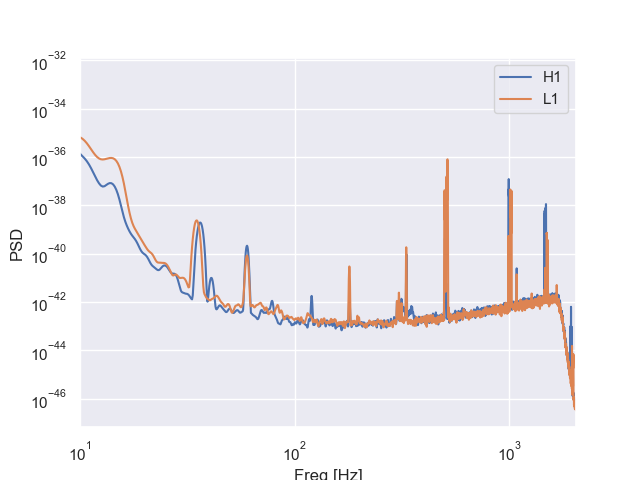

In [59]:
plt.figure()

plt.plot(paH1freqs, Rxpa_estH1, label='H1')
plt.plot(paL1freqs, Rxpa_estL1, label='L1')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Freq [Hz]')
plt.ylabel('PSD')
plt.xlim(10, fs/2)
plt.legend()
leg = InteractiveLegend()

En primer lugar, si se comparan estos espectros con la imagen descriptiva presente en la consigna de este trabajo, se puede ver una coincidencia. El espectro comienza de un valor alto, disminuye rapidamente y luego vuelve a crecer hasta que en approx. 2KHz se encuentra el filtro Antialias. Es notable el hecho de que la vanda de los 100Hz a 300Hz donde se encuentra la señal del pulso gravitatorio se encuentra en un valle, tal como en la imagen.

Lo notable son los picos espectrales presentes, algunos de ellos son el fundamental y los armonicos de la tension de linea estadounidense de 60Hz. Otros picos se encuentran en frecuencias menores de approx. 35Hz. El pico mas notable se encuentra en approx. 514Hz y los siguientes son sus armonicos. 

No podemos explicar de donde vienen todos los picos espectrales.

# Filtrado

In [ ]:
# Creditos: https://gwosc.org/tutorials/

# La funcion de whitening que utilizan escala el espectro de la señal por 1/sqrt(PSD) para blanquear el ruido sin modificar la fase de la señal.

def whiten(strain, dt, psd_interp, phase_shift=0, time_shift=0):
    """Whitens strain data given the psd and sample rate, also applying a phase
    shift and time shift.

    Args:
        strain (ndarray): strain data
        interp_psd (interpolating function): function to take in freqs and output 
            the average power at that freq 
        dt (float): sample time interval of data
        phase_shift (float, optional): phase shift to apply to whitened data
        time_shift (float, optional): time shift to apply to whitened data (s)
    
    Returns:
        ndarray: array of whitened strain data
    """
    Nt = len(strain)
    # take the fourier transform of the data
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by square root of psd, then
    # transform back, taking care to get normalization right.
    hf = np.fft.rfft(strain)
    
    # apply time and phase shift
    hf = hf * np.exp(-1.j * 2 * np.pi * time_shift * freqs - 1.j * phase_shift)
    white_hf = hf / np.sqrt(psd_interp(freqs))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

def bandpass(fl, fh, data):
    b, a = sg.butter(4, [fl, fh], btype='bandpass', fs=fs)
    normalization = np.sqrt((fh-fl)/(fs/2))
    return sg.filtfilt(b, a, data) / normalization

In [ ]:


dataH1 = strain_H1[indxt_around_H1]
dataL1 = strain_L1[indxt_around_L1]

L1_psd_interp = lambda x: np.interp(x, paL1freqs, Rxpa_estL1)
H1_psd_interp = lambda x: np.interp(x, paH1freqs, Rxpa_estH1)

whitened_dH1 = whiten(dataH1, 1/fs, H1_psd_interp)
whitened_dL1 = whiten(dataL1, 1/fs, L1_psd_interp)
white_testH1 = whiten(strain_H1_before_noise, 1/fs, H1_psd_interp)
white_testL1 = whiten(strain_L1_before_noise, 1/fs, L1_psd_interp)

filteredH1 = bandpass(35, 350, whitened_dH1)
filteredL1 = bandpass(35, 350, whitened_dL1)


En el siguiente grafico se ve una muestra de las mediciones pasadas por la funcion de blanqueo de espectro, y se puede ver un espectro comparativamente mas plano.

In [ ]:
fH1, pH1, _ = periodogram_averaging(white_testH1, 4096, 2, sg.windows.blackman)
fL1, pL1, _ = periodogram_averaging(white_testL1, 4096, 2, sg.windows.blackman)
plt.figure()
plt.plot(fH1, pH1, label='Withened H1')
plt.plot(fL1, pL1, label='Withened L1')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Freq [Hz]')
plt.ylabel('PSD')
plt.xlim(10, fs/2)
plt.legend()

In [ ]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
plt.plot(time_H1[indxt_around_H1], filteredH1)
plt.title('H1')
plt.subplot(2, 1, 2)
plt.plot(time_L1[indxt_around_L1], filteredL1)
plt.title('L1')


In [ ]:
audio = filteredH1[int(0.5*fs):-int(0.5*fs)]
audioobj = ipd.Audio(audio, rate=fs, normalize=True)
audioobj

In [ ]:
import soundfile
soundfile.write('GW.wav', audio, fs) 

Espectrograma de la muestra de 4 segundos de H1 luego de pasarla por el blanqueo y el filtro pasabanda. Se puede ver claramente el lugar temporal donde ocurre el evento.

In [ ]:
import pywt

data = filteredH1[int(0.5*fs):-int(0.5*fs)]
widths = np.arange(1, 150) #Frecuency range
cwt1, freqs = pywt.cwt(data, widths, 'morl')
cwt2, freqs = pywt.cwt(data, widths, 'mexh')
cwt = cwt1+cwt2
plt.figure()
plt.imshow(X=10*np.log10(abs(cwt)), aspect='auto', vmin = -10)
plt.colorbar()
plt.grid(False)

Aqui se calcula la correlacion cruzada entre intervalos de distintos tiempos que contienen a la señal deseada, y con esto se puede calcular el lag entre cada evento.

In [ ]:
plt.figure()
center_sample = 9750


H1_1s = filteredH1[center_sample-int(0.5*fs): center_sample+int(0.5*fs)]
H1_400ms = filteredH1[center_sample-int(0.2*fs): center_sample+int(0.2*fs)]
H1_200ms = filteredH1[center_sample-int(0.1*fs): center_sample+int(0.1*fs)]

L1_1s = filteredL1[center_sample-int(0.5*fs): center_sample+int(0.5*fs)]
L1_400ms = filteredL1[center_sample-int(0.2*fs): center_sample+int(0.2*fs)]
L1_200ms = filteredL1[center_sample-int(0.1*fs): center_sample+int(0.1*fs)]

cross_corr_long = sg.correlate(filteredH1, filteredL1)/len(filteredH1)
lags_long = sg.correlation_lags(len(filteredH1), len(filteredL1))
cross_corr_1s = sg.correlate(H1_1s, L1_1s)/len(H1_1s)
lags_1s = sg.correlation_lags(len(H1_1s), len(L1_1s))
cross_corr_400ms = sg.correlate(H1_400ms, L1_400ms)/len(H1_400ms)
lags_400ms = sg.correlation_lags(len(H1_400ms), len(L1_400ms))
cross_corr_200ms = sg.correlate(H1_200ms, L1_200ms)/len(H1_200ms)
lags_200ms = sg.correlation_lags(len(H1_200ms), len(L1_200ms))


print("Tiempo de correlacion minima: ", lags_long[np.argmin(cross_corr_long)]/fs)
print("Tiempo de correlacion minima: ", lags_1s[np.argmin(cross_corr_1s)]/fs)
print("Tiempo de correlacion minima: ", lags_400ms[np.argmin(cross_corr_400ms)]/fs)
print("Tiempo de correlacion minima: ", lags_200ms[np.argmin(cross_corr_200ms)]/fs)

plt.plot(lags_long/fs, cross_corr_long)
plt.plot(lags_1s/fs, cross_corr_1s)
plt.plot(lags_400ms/fs, cross_corr_400ms)
plt.plot(lags_200ms/fs, cross_corr_200ms)
plt.xlim(0, 15e-3)
plt.ylim(-2, 2)

Dado que el lag se calculo en 7.32ms, y la distancia entre H y L es de approx 10ms*C, se puede calcular el angulo de incidencia:

In [ ]:
L2H = 10            # tiempo entre nodos a la velocidad de la luz en ms
lag = 7.32421875

phi = np.rad2deg(np.arcsin(lag/L2H))

print(f"El angulo del cono de donde se puede proyectar la onda recibida es de: {phi:0.3}º")

# $\textit{Estacionalidad}$

fuentes: https://arch.readthedocs.io/en/latest/unitroot/unitroot_examples.html

In [10]:
len(strain_L1_before_noise)

53248

In [32]:
from arch.unitroot import ADF

''' 
Para el test, se tiene en cuenta que las hipotesis son:

H0: La serie contiene raiz unitaria.
H1: La serie es estacionaria.

Si el p-valor esta por encima del critico, la hipotesis nula no puede ser rechazada, indicando que 
la serie no es estacionaria.
'''

norm1 = strain_L1_before_noise/strain_L1_before_noise.max()
norm2 = strain_H1_before_noise/strain_H1_before_noise.max()
max_lags_test=len(strain_L1_before_noise)//500

adf = ADF(norm1, max_lags=max_lags_test)
print(adf.summary().as_text())
print("Dado que P-value = 0, podemos concluir que la señal L1 es estacionaria.")
print('\n//////////////////////////////////////\n')

adf = ADF(norm2, max_lags=max_lags_test)
print(adf.summary().as_text())
print("Dado que P-value = 0, podemos concluir que la señal H1 es estacionaria.")

   Augmented Dickey-Fuller Results   
Test Statistic                -23.167
P-value                         0.000
Lags                              106
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
Dado que P-value = 0, podemos concluir que la señal L1 es estacionaria.

//////////////////////////////////////

   Augmented Dickey-Fuller Results   
Test Statistic                -18.939
P-value                         0.000
Lags                              104
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
Dado que P-value = 0, podemos concluir que la señal H1 es estacionaria.


In [31]:
from arch.unitroot import PhillipsPerron

pp = PhillipsPerron(norm1)
print(pp.summary().as_text())
print("Dado que P-value = 0, podemos concluir que la señal L1 es estacionaria.")
print('\n//////////////////////////////////////\n')

pp = PhillipsPerron(norm2)
print(pp.summary().as_text())
print("Dado que P-value = 0, podemos concluir que la señal H1 es estacionaria.")

     Phillips-Perron Test (Z-tau)    
Test Statistic                -13.616
P-value                         0.000
Lags                               58
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

//////////////////////////////////////

     Phillips-Perron Test (Z-tau)    
Test Statistic                -10.306
P-value                         0.000
Lags                               58
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [41]:
from arch.unitroot import KPSS

kpss1 = KPSS(norm1)
print(kpss1.summary())

kpss2 = KPSS(norm2)
print(kpss2.summary())

print("Los resultados de los tests muestran que L1 y H1 son estacionarios.")

    KPSS Stationarity Test Results   
Test Statistic                  0.002
P-value                         0.999
Lags                              137
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
    KPSS Stationarity Test Results   
Test Statistic                  0.022
P-value                         0.994
Lags                              137
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
Los resultados de los tests muestran que L1 y H1 son estacionarios.
